In [21]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pysam
import pyBigWig
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

# Distance from nearest hetSNP to hetSV

In [1]:
def load_het_snps(f_vcf):
    snps = []
    with pysam.VariantFile(f_vcf) as f:
        sample = list(f.header.samples)[0]
        for record in f:
            gt = record.samples[sample]["GT"]
            a1, a2 = record.alleles[gt[0]], record.alleles[gt[1]]          
            if len(a1) > 1 or len(a2) > 1 or a1 == a2:
                continue
            if len(record.ref) > 1:
                continue
            name = "%s/%s" % (a1, a2)
            snp = GRange(chrom=record.contig, start=record.start, end=record.stop, name=name)
            snps.append(snp)
    snps.sort()
    return snps

# def get_closest_snp(sv, loader, width=20000):
#     closest_distance = None
#     closest_snp = None
#     for snp in loader.fetch(chrom=sv.chrom, start=sv.start - width, end = sv.end + width):
#         if snp.end < sv.start:
#             distance = sv.start - snp.end
#         elif snp.start > sv.end:
#             distance = snp.start - sv.end
#         else:
#             continue
#         if distance < 10:
#             continue
#         if closest_snp is None:
#             closest_distance = distance
#             closest_snp = snp
#         elif distance <= closest_distance:
#             closest_distance = distance
#             closest_snp = snp
#         else:
#             break
#     return closest_distance, closest_snp

def get_closest_snp(sv, loader, width=20000):
    array = []
    for snp in loader.fetch(chrom=sv.chrom, start=sv.start - width, end = sv.end + width):
        if snp.end < sv.start:
            distance = sv.start - snp.end
        elif snp.start > sv.end:
            distance = snp.start - sv.end
        else:
            distance = 0
        array.append([distance, snp])
    array = list(filter(lambda item: item[0] >= 10, array))
    array.sort()
    if len(array) > 0:
        return array[0][0], array[0][1]
    else:
        return None, None

def get_distances(svs, snps):
    distances = []
    width = 20000
    loader = ShiftLoader(snps)
    for sv in svs:
        closest_distance, closest_snp = get_closest_snp(sv, loader, width)
        if closest_distance is None:
            closest_distance = width
        distances.append(closest_distance)
    return distances

In [7]:
# load SVs

data_svs = dict()

# HG001

svs = []
dat = pd.read_csv("results/quant_phased_svs.HG001_Cell_350.tsv", sep="\t")
dat = dat[(dat["GenoType"] == "0|1") | (dat["GenoType"] == "1|0")]
for chrom, start, end, name in dat[["Chrom_HP1", "Start_HP1", "End_HP1", "Name_HP1"]].values:
    sv = GRange(chrom=chrom, start=start, end=end, name=name)
    svs.append(sv)
svs.sort()
print(len(svs))
data_svs["HG001_hetSVs"] = svs

# HG002

svs = []
with pysam.VariantFile("../../public/GRCh38_HG002_NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz") as f:
    sample = list(f.header.samples)[0]
    for record in f:
        if list(record.filter)[0] != "PASS":
            continue
        gt = record.samples[sample]["GT"]
        if gt[0] == gt[1]:
            continue
        chrom = "chr%s" % record.contig
        sv = GRange(chrom=chrom, start=record.start, end=record.stop, name=record.id)
        sv.record = record
        svs.append(sv)
svs.sort()
print(len(svs))
data_svs["HG002_hetSVs"] = svs

6010
6938


In [8]:
# load SNPs
data_snps = dict()
data_snps["HG001_NSS_hetSNPs"] = load_het_snps("../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz")
data_snps["HG001_GIAB_hetSNPs"] = load_het_snps("/lustre/grp/tfclab/chenzg/repositories/GRCh38_HG001_SNP_Indel/GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.vcf.gz")
data_snps["HG001_Pacbio_hetSNPs"] = load_het_snps("../../3_NanoStrandSeq_PseudoBulk/results/snvs/concated/nanocaller/PacBio.full.vcf.gz")
data_snps["HG002_GIAB_hetSNPs"] = load_het_snps("../../public/GIAB/HG002/HG002_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.corrected.vcf.gz")

[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz.tbi


HG001_hetSVs	HG001_NSS_hetSNPs
HG001_hetSVs	HG001_GIAB_hetSNPs
HG001_hetSVs	HG001_Pacbio_hetSNPs
HG002_hetSVs	HG002_GIAB_hetSNPs


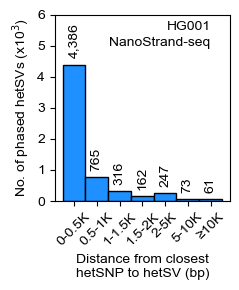

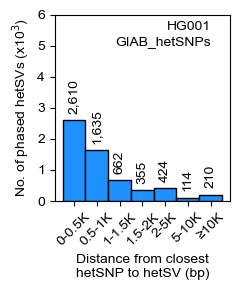

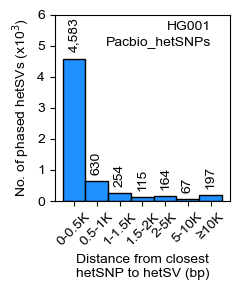

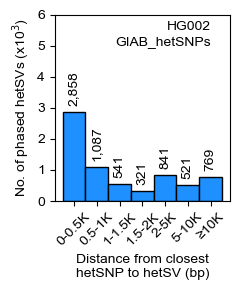

In [11]:
pairs = [
    ["HG001_hetSVs", "HG001_NSS_hetSNPs"],
    ["HG001_hetSVs", "HG001_GIAB_hetSNPs"],
    ["HG001_hetSVs", "HG001_Pacbio_hetSNPs"],
    ["HG002_hetSVs", "HG002_GIAB_hetSNPs"]
]

for k1, k2 in pairs:
    print(k1, k2, sep="\t")
    svs = data_svs[k1]
    snps = data_snps[k2]
    distances = get_distances(svs, snps)
    counts = [
        len(list(filter(lambda v: 0 <= v < 500, distances))),
        len(list(filter(lambda v: 500 <= v < 1000, distances))),
        len(list(filter(lambda v: 1000 <= v < 1500, distances))),
        len(list(filter(lambda v: 1500 <= v < 2000, distances))),
        len(list(filter(lambda v: 2000 <= v < 5000, distances))),
        len(list(filter(lambda v: 5000 <= v < 10000, distances))),
        len(list(filter(lambda v: 10000 <= v, distances))),
    ]
    xs = np.arange(len(counts))
    xticks = ["0-0.5K", "0.5-1K", "1-1.5K", "1.5-2K", "2-5K", "5-10K", "≥10K"]
    plt.figure(figsize=(2.5, 3))
    plt.bar(xs, counts, color="dodgerblue", edgecolor="black", width=1)
    for x, y in zip(xs, counts):
        if x >= 0:
            plt.text(x, y + 200, format(y, ","), ha="center", va="bottom", rotation=90)
    if True:
        plt.text(len(counts) - 1, 5500, k1.split("_")[0], ha="right")
        s = k2.split("_")[1]
        if s == "NSS":
            s = "NanoStrand-seq"
        else:
            s = "%s_hetSNPs" % s
        plt.text(len(counts) - 1, 5000, s, ha="right")
    plt.xlabel("Distance from closest\nhetSNP to hetSV (bp)")
    plt.xticks(xs, xticks, rotation=45, ha="center")
    plt.ylabel("No. of phased hetSVs (x10$^3$)")
    ys = np.arange(0, 6000 + 1, 1000)
    plt.yticks(ys, [int(y/1000) for y in ys])
    plt.tight_layout()
    plt.savefig("figures/distance_from_snp_to_sv.%s_and_%s.pdf" % (k1, k2), dpi=300)
    # break

In [12]:
pairs = [
    ["HG001_hetSVs", "HG001_NSS_hetSNPs"],
    ["HG001_hetSVs", "HG001_GIAB_hetSNPs"],
    ["HG001_hetSVs", "HG001_Pacbio_hetSNPs"],
    ["HG002_hetSVs", "HG002_GIAB_hetSNPs"]
]

svs = data_svs["HG001_hetSVs"]
snps = data_snps["HG001_NSS_hetSNPs"]
distances = get_distances(svs, snps)
mapper = {sv.name: distance for sv, distance in zip(svs, distances)}
dat["Nearest_hetSNP_Distance"] = [mapper[name] for name in dat["Name_HP1"]]

In [13]:
dat.to_csv("results/HG001_hetSVs_HG001_NSS_hetSNPs.distances.tsv", sep="\t", index=False)

# Characteristic of SVs that far away from hetSNP

In [3]:
dat = pd.read_csv("results/HG001_hetSVs_HG001_NSS_hetSNPs.distances.tsv", sep="\t")
svs = []
for chrom, start, end, name, gt, distance in dat[["Chrom_HP1", "Start_HP1", "End_HP1", "Name_HP1", "GenoType", "Nearest_hetSNP_Distance"]].values:
    sv = GRange(chrom=chrom, start=start, end=end, name=name, strand="+")
    sv.genotype = gt
    sv.score = distance
    sv.het_snp_distance = distance
    svs.append(sv)
svs.sort()

with open("results/HG001_phased_hetSVs.bed", "w+") as fw:
    for sv in svs:
        fw.write(sv.format() + "\n")

In [4]:
labels = ["0 - 500", "500 - 5,000", "≥ 5,000"]
colors = ["C7", "C0", "C3"]

svs_list_raw = [
        list(filter(lambda sv: 0 <= sv.het_snp_distance < 500, svs)),
        list(filter(lambda sv: 500 <= sv.het_snp_distance < 5000, svs)),
        list(filter(lambda sv: 5000 <= sv.het_snp_distance, svs)),
    ]
svs_list = svs_list_raw
[len(x) for x in svs_list]

[4386, 1490, 134]

In [5]:
if True: # downsample SVs
    tmp = []
    random.seed(0)
    for x in svs_list:
        tmp.append(random.sample(x, 134))
    svs_list = tmp
[len(x) for x in svs_list]

[134, 134, 134]

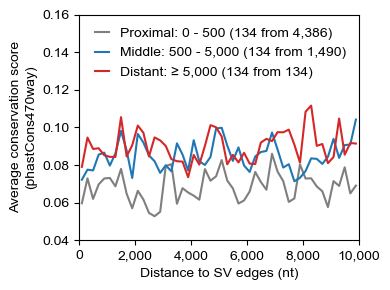

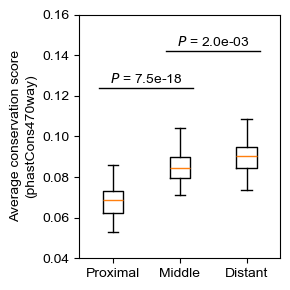

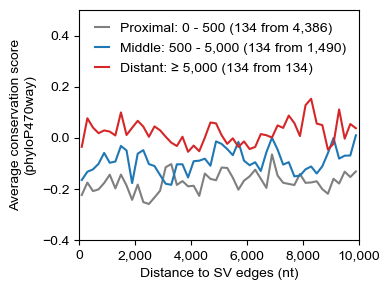

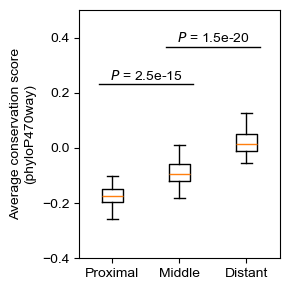

In [10]:
params = [
    ["phastCons470way", "/lustre/grp/tfclab/chenzg/species/homo_sapiens/ucsc/hg38.phastCons470way.bw", [0.04, 0.16]],
    ["phyloP470way", "/lustre/grp/tfclab/chenzg/species/homo_sapiens/ucsc/hg38.phyloP470way.bw", [-0.4, 0.5]]
]
groups = ["Proximal", "Middle", "Distant"]

for name, f_bw, (ylim1, ylim2) in params:
    data = []
    width = 10000
    step = 200
    
    bw = pyBigWig.open(f_bw)
    for svs1 in svs_list:
        rows = []
        for sv in svs1:
            vs1 = np.nan_to_num(bw.values(sv.chrom, sv.start - width - 200, sv.start - 200), 0)[::-1]
            vs2 = np.nan_to_num(bw.values(sv.chrom, sv.end + 200, sv.end + width + 200), 0)
            rows.append(np.mean(vs1.reshape((-1, step)), axis=1))
            rows.append(np.mean(vs2.reshape((-1, step)), axis=1))
        data.append(np.array(rows))
    bw.close()
    
    plt.figure(figsize=(4, 3))
    for i, m in enumerate(data):
        xs = np.arange(len(m[0])) * step + step / 2
        ys = np.mean(m, axis=0)
        yerr = np.std(m, axis=0)
        plt.plot(xs, ys, color=colors[i], 
                 label="%s: %s (%s from %s)" % (groups[i], 
                                                labels[i], 
                                                format(int(len(m)/2), ","), 
                                                format(len(svs_list_raw[i]), ",")))
    xs = np.arange(0, 10000 + 1, 2000)
    ticks = [format(x, ",") for x in xs]
    plt.xticks(xs, ticks)
    plt.xlim(0, width)
    plt.xlabel("Distance to SV edges (nt)")
    plt.ylim(ylim1, ylim2)
    plt.ylabel("Average conservation score\n(%s)" % name)
    plt.legend(handlelength=1, frameon=False)
    plt.tight_layout()
    plt.savefig("figures/conservation_score.lines.%s.pdf" % name, dpi=300)
    
    plt.figure(figsize=(3, 3))
    array = [np.mean(m, axis=0) for m in data]
    plt.boxplot(array, showfliers=False) # axis的值影响很大
    plt.ylim(ylim1, ylim2)
    h = ylim2 - ylim1
    y1 = ylim1 + h * 0.7
    y2 = ylim1 + h * 0.85
    plt.plot([1 - 0.2, 2 + 0.2], [y1, y1], lw=1, color="black")
    plt.plot([2 - 0.2, 3 + 0.2], [y2, y2], lw=1, color="black")
    plt.text(1.5, y1 + h * 0.02, "$\it{P}$ = %.1e" % ttest_ind(array[0], array[1])[1], ha="center")
    plt.text(2.5, y2 + h * 0.02, "$\it{P}$ = %.1e" % ttest_ind(array[1], array[2])[1], ha="center")
    plt.ylabel("Average conservation score\n(%s)" % name)
    plt.xticks([1, 2, 3], ["Proximal", "Middle", "Distant"])
    plt.tight_layout()
    plt.savefig("figures/conservation_score.violin.%s.pdf" % name, dpi=300)

In [11]:
svs = svs_list_raw[-1].copy()
svs.sort()
print("Number of SVs:", len(svs))

Number of SVs: 134


In [14]:
with BedFile("/lustre/grp/tfclab/chenzg/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = [x for x in f]
print("Number of transcripts:", len(transcripts))

Number of transcripts: 244939


In [15]:
transcripts = list(sorted(filter(lambda t: t.thick is not None, transcripts)))
print("Number of transcripts with CDS:", len(transcripts))

Number of transcripts with CDS: 107497


In [19]:
print("Location\tSV")
print("-" * 40)
loader = ShiftLoader(transcripts)
array = []
for sv in svs:
    if sv.het_snp_distance < 10000:
        continue
    sv.gene_loc = None
    distance = np.inf
    for t in loader.fetch(chrom=sv.chrom, start=sv.start - 100000, end=sv.end + 100000):
        if t.end < sv.start:
            dis = sv.start - t.end
        elif t.start > sv.end:
            dis = t.start - sv.end
        else:
            dis = 0
            loc = "intron"
            for block in t.blocks:
                if max(block[0], sv.start) < min(block[1], sv.end):
                    loc = "exon"
            sv.gene_loc = loc
        if distance is None:
            distance = dis
        else:
            distance = min(distance, dis)
    if distance == 0:
        # print(sv.format())
        print(sv.gene_loc, "%s:%d-%d" % (sv.chrom, sv.start, sv.end), sep="\t")
    array.append(distance)

Location	SV
----------------------------------------
exon	chr1:59296667-59296718
intron	chr1:97316516-97316517
intron	chr1:186327185-186327186
intron	chr10:119313031-119313032
intron	chr10:133291292-133292484
intron	chr11:576799-576875
intron	chr12:49436512-49436593
intron	chr14:49652156-49652314
intron	chr15:50340879-50340950
intron	chr15:66039838-66039939
intron	chr16:57860067-57860068
intron	chr17:7037068-7037443
intron	chr17:47557415-47557918
intron	chr18:75012294-75012398
intron	chr20:49325676-49325677
intron	chr3:51588356-51588357
intron	chr3:177225153-177225154
intron	chr4:81753714-81754311
intron	chr6:125962231-125962284
intron	chr6:163013382-163013535
intron	chr7:746388-746389
intron	chr9:133391177-133391229
exon	chrX:47233763-47233816
intron	chrX:53578701-53578925
intron	chrX:136023187-136023240
exon	chrX:155057022-155057451


In [22]:
array = np.array(array)
array = np.sort(array)
a = sum(array == 0)
c = sum(array > 100000)
b = len(array) - a - c
print("SVs overlap with transcript:", a)
print("SVs in intergenic (0-100k):", b)
print("SVs in intergenic (>100k):", c)

SVs overlap with transcript: 26
SVs in intergenic (0-100k): 16
SVs in intergenic (>100k): 19
